In [1]:
!pip install imutils
!pip install -U torchvision
#!pip install torchsummary

In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import random
import xml.etree.ElementTree as ET 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from torchsummary import summary

In [2]:
print(torchvision.__version__)

0.16.0+cpu


In [1]:
import torch

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

<span style="font-size:25px;">**Check if GPU is available**</span>

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

Using cuda device


<span style="font-size:25px;">**Display example data**</span>

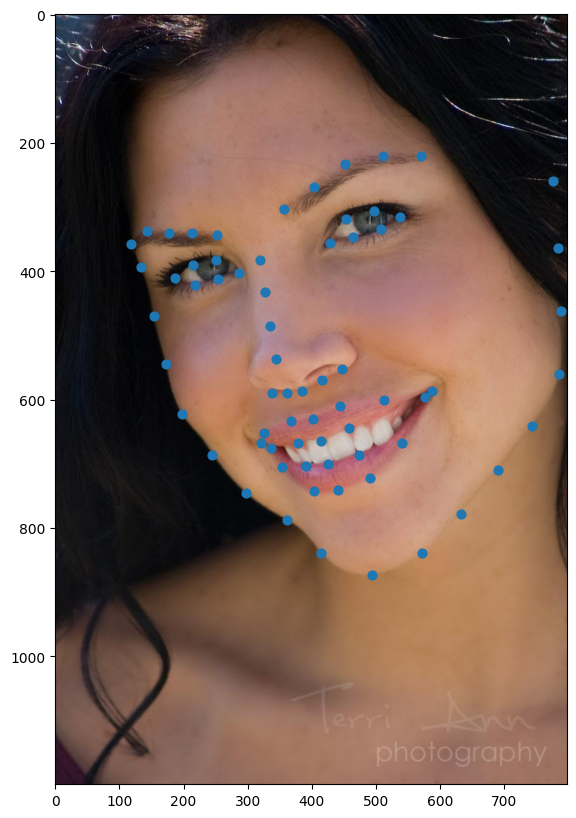

In [5]:
file = open('ibug_300W_large_face_landmark_dataset/helen/testset/2986046144_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/testset/2986046144_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 40)
plt.show()

<span style="font-size:25px;">**Data preprocessing**</span>

To prevent the neural network from overfitting the training dataset, the dataset is transoformed randomly. The following operations are applied to the training and validation dataset:
* Since the face occupies a very small portion of the entire image, crop the image and use only the face for training.
* Resize the cropped face into a (224x224) image.
* Randomly change the brightness and saturation of the resized face.
* Randomly rotate the face after the above three transformations.
* Convert the image and landmarks into torch tensors and normalize them between [-1, 1].

In [6]:
class Transforms():
    def __init__(self):
        pass
    
    def crop_face(self, image, landmarks, crops):
        top = int(crops['top'])
        left = int(crops['left'])
        height = int(crops['height'])
        width = int(crops['width'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks
    
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks
    
    def color_jitter(self, image, landmarks):
        #ranNum = random.random()
        color_jitter = transforms.ColorJitter(brightness=random.random(), 
                                              contrast=random.random(),
                                              saturation=random.random(), 
                                              hue=random.uniform(0,0.5))
        image = color_jitter(image)
        return image, landmarks
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks
    
    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=random.randint(-20,20))
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

<span style="font-size:25px;">**Dataset Preparation**</span>

The labels_ibug_300W_train.xml contains the image path, landmarks and coordinates for the bounding box. Store these values in lists to access them easily during training.

In [7]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train_eyes.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(12):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

OriDataset = FaceLandmarksDataset()

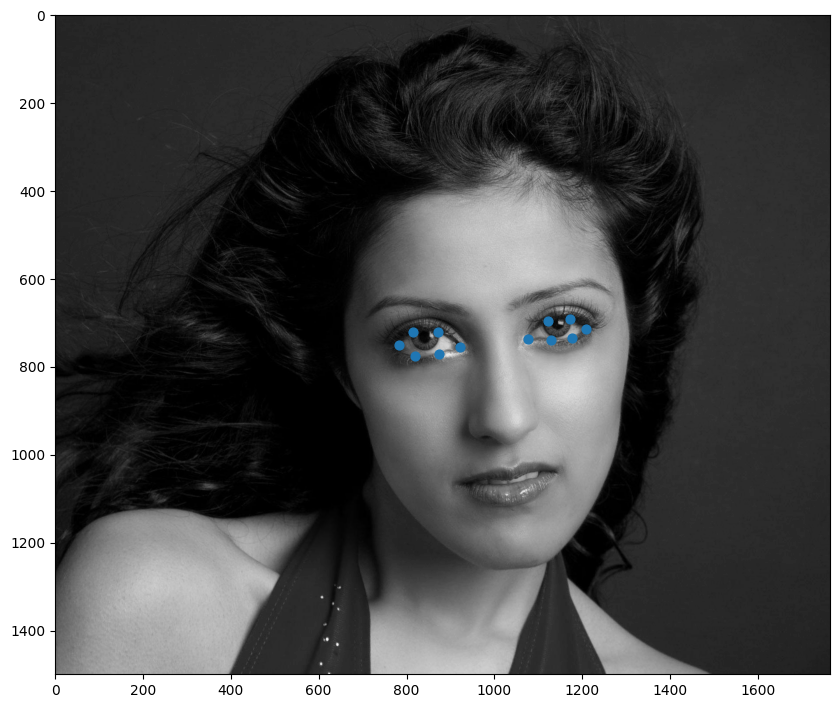

In [8]:
image, landmarks = OriDataset[5]
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=40);

<span style="font-size:25px;">**Example of image after pre-processing**</span>

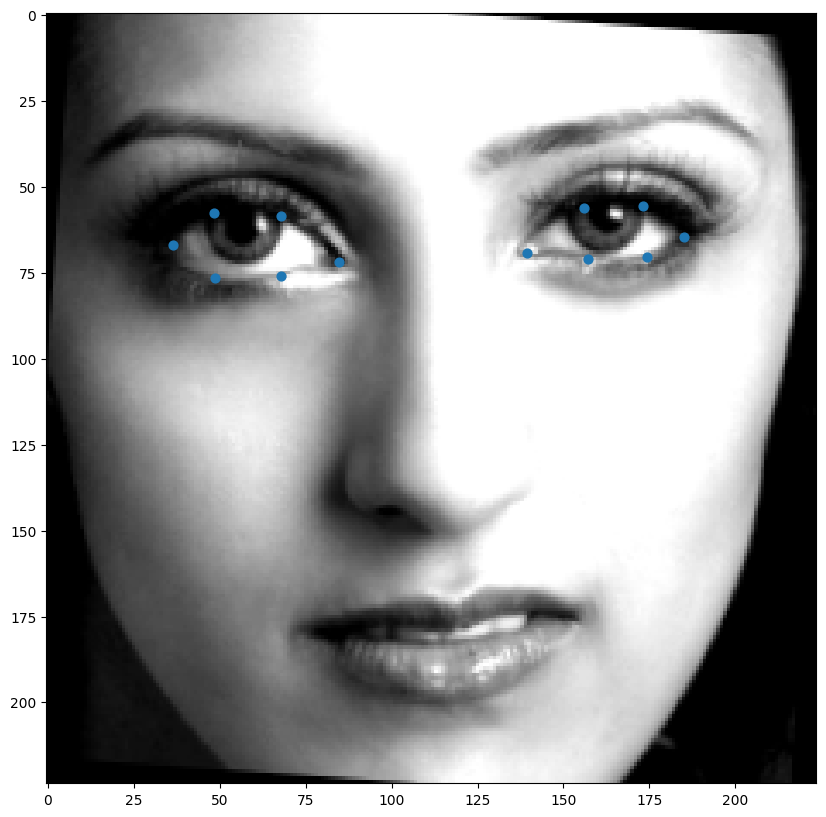

In [9]:
dataset = FaceLandmarksDataset(Transforms())

image, landmarks = dataset[5]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=40);

In [10]:
# Train-Test split
len_test_set = int(0.2*len(dataset))
len_train_set = len(dataset) - len_test_set 

print("The length of Train set is {}".format(len_train_set))
print("The length of Test set is {}".format(len_test_set))

train_dataset , test_dataset = torch.utils.data.random_split(dataset , [len_train_set, len_test_set])

# setting batch sizes and shuffle the data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

The length of Train set is 5333
The length of Test set is 1333


In [11]:
images, landmarks = next(iter(train_loader))
#torch.set_printoptions(profile="full")
#print(images.shape)
#print(landmarks.shape)
print(f"Images batch shape: {images.size()}")
print(f"Landmarks batch shape: {landmarks.size()}")

In [13]:
images, landmarks = next(iter(test_loader))
print(f"Images batch shape: {images.size()}")
print(f"Landmarks batch shape: {landmarks.size()}")

In [11]:
class ResNet50(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [12]:
class ResNet101(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet101'
        self.model=models.resnet101()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [13]:
class Inception(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='inceptionv3'
        self.model=models.inception_v3()
        self.model.Conv2d_1a_3x3.conv=nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
        self.model.AuxLogits.fc = nn.Linear(self.model.AuxLogits.fc.in_features, num_classes)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [14]:
class DenseNet(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='densenet'
        self.model = models.densenet161()
        self.model.features.conv0=nn.Conv2d(1, 96, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [15]:
class EfficientNet(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='efficientnet'
        self.model = models.efficientnet_b0()
        self.model.features[0][0]=nn.Conv2d(1, 21, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1]= nn.Linear(self.model.classifier[1].in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [16]:
class ConvNeXt(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='convnext'
        self.model = models.convnext_base()
        self.model.features[0][0]=nn.Conv2d(1, 128, kernel_size=4, stride=4, bias=False)
        self.model.classifier[2]= nn.Linear(self.model.classifier[2].in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [17]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

##### if os.path.isdir('progress'):
    !rm -rf progress
os.mkdir('progress')

In [18]:
model1 = ResNet50()
model3 = Inception()
model4 = DenseNet()
model5 = EfficientNet()
model6 = ConvNeXt()

c:\Users\Asus-FPT\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [19]:
def train_test(model, epochs, learning_rate, train_loader, test_loader):
    torch.autograd.set_detect_anomaly(True)
    network = model
    network.to(device)    

    criterion = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    num_epochs = epochs
    loss_min = np.inf
    
    train_loss_record = []
    test_loss_record = []

    start_time = time.time()
    for epoch in range(1,num_epochs+1):

        loss_train = 0
        loss_test = 0
        running_loss = 0

        network.train()
        for step in range(1,len(train_loader)+1):

            images, landmarks = next(iter(train_loader))

            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0),-1).to(device) 

            predictions = network(images)

            # clear all the gradients before calculating them
            optimizer.zero_grad()

            # find the loss for the current step
            loss_train_step = criterion(predictions, landmarks)
            #loss_valid_step = criterion(predictions.logits, landmarks)

            # calculate the gradients
            loss_train_step.backward()

            # update the parameters
            optimizer.step()

            loss_train = loss_train + loss_train_step.item()
            running_loss = loss_train/step

            print_overwrite(step, len(train_loader), running_loss, 'train')

        network.eval() 
        with torch.no_grad():

            for step in range(1,len(test_loader)+1):

                images, landmarks = next(iter(test_loader))

                images = images.to(device)
                landmarks = landmarks.view(landmarks.size(0),-1).to(device)

                predictions = network(images)

                # find the loss for the current step
                loss_test_step = criterion(predictions, landmarks)
                #loss_valid_step = criterion(predictions.logits, landmarks)

                loss_test = loss_test + loss_test_step.item()
                running_loss = loss_test/step

                print_overwrite(step, len(test_loader), running_loss, 'test')

        loss_train = loss_train / len(train_loader)
        loss_test = loss_test / len(test_loader)

        print('\n--------------------------------------------------')
        print('Epoch: {}  Train Loss: {:.6f}  Test Loss: {:.6f}'.format(epoch, loss_train, loss_test))
        print('--------------------------------------------------')
        
        train_loss_record.append(loss_train)
        test_loss_record.append(loss_test)

        if loss_test < loss_min:
            loss_min = loss_test
            torch.save(network.state_dict(), '/progress.pth') 
            print("\nMinimum Test Loss of {:.6f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
            print('Model Saved\n')

    print('Training Complete')
    print("Total Elapsed Time : {} s".format(time.time()-start_time))
    
    plt.subplot(1,2,1)
    plt.title("Train Loss")
    plt.plot(train_loss_record)
    plt.xticks(range(1,len(train_loss_record)+1, 1))
    plt.ylabel('MSE Loss') 
    plt.xlabel('Epochs')
    
    plt.subplot(1,2,2)
    plt.title("Test Loss")
    plt.plot(test_loss_record)
    plt.xticks(range(1,len(test_loss_record)+1, 1))
    plt.ylabel('MSE Loss') 
    plt.xlabel('Epochs')

In [20]:
def show_result(model, test_loader):
    start_time = time.time()

    with torch.no_grad():

        best_network = model
        best_network.to(device)
        best_network.load_state_dict(torch.load('/progress.pth')) 
        best_network.eval()

        images, landmarks = next(iter(test_loader))

        images = images.to(device)
        landmarks = (landmarks + 0.5) * 224

        predictions = (best_network(images).cpu() + 0.5) * 224
        predictions = predictions.view(-1,68,2)

        plt.figure(figsize=(10,40))

        for img_num in range(4):
            plt.subplot(1,4,img_num+1)
            plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
            plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
            plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

    print('Total number of test images: {}'.format(len(test_dataset)))

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time)) 

In [21]:
train_test(model1, 10, 0.0001, train_loader, test_loader)
show_result(model1, test_loader)

In [ ]:
#train_test(model3, 10, 0.0001, train_loader, test_loader)
#show_result(model3, test_loader)

In [ ]:
#train_test(model4, 10, 0.0001, train_loader, test_loader)
#show_result(model4, test_loader)

In [ ]:
#train_test(model5, 10, 0.0001, train_loader, test_loader)
#show_result(model5, test_loader)

In [ ]:
# train_test(model6, 10, 0.0001, train_loader, test_loader)
# show_result(model6, test_loader)

----------------------------------------------------

In [ ]:
train_test(model1, 10, 0.0005, train_loader, test_loader)
show_result(model1, test_loader)

In [ ]:
#train_test(model3, 10, 0.0005, train_loader, test_loader)
#show_result(model3, test_loader)

In [ ]:
train_test(model4, 10, 0.0005, train_loader, test_loader)
show_result(model4, test_loader)

In [ ]:
#train_test(model5, 10, 0.0005, train_loader, test_loader)
#show_result(model5, test_loader)

In [ ]:
train_test(model6, 10, 0.0005, train_loader, test_loader)
show_result(model6, test_loader)

----------------------------------------------------

In [ ]:
train_test(model1, 20, 0.0001, train_loader, test_loader)
show_result(model1, test_loader)

In [ ]:
train_test(model3, 20, 0.0001, train_loader, test_loader)
show_result(model3, test_loader)

In [ ]:
train_test(model4, 20, 0.0001, train_loader, test_loader)
show_result(model4, test_loader)

In [ ]:
train_test(model5, 20, 0.0001, train_loader, test_loader)
show_result(model5, test_loader)

In [ ]:
train_test(model6, 20, 0.0001, train_loader, test_loader)
show_result(model6, test_loader)

----------------------------------------------------

In [ ]:
train_test(model1, 20, 0.0005, train_loader, test_loader)
show_result(model1, test_loader)

In [ ]:
#train_test(model3, 20, 0.0005, train_loader, test_loader)
#show_result(model3, test_loader)

In [ ]:
train_test(model4, 20, 0.0005, train_loader, test_loader)
show_result(model4, test_loader)

In [ ]:
train_test(model5, 20, 0.0005, train_loader, test_loader)
show_result(model5, test_loader)

In [ ]:
train_test(model6, 20, 0.0005, train_loader, test_loader)
show_result(model6, test_loader)